## Run RCM on the datasets

### Generating the data for Figure 2
Here we want to run the regulatory clutsering model on our proteomics, RNAseq and DNA methylation datasets.

In [1]:
import os
import pandas as pd
import seaborn as sns
from sciviso import Scatterplot
from scircm import SciRCM
from scivae import Vis
import matplotlib.pyplot as plt
import os
import pandas as pd
from collections import defaultdict
from sciutil import SciUtil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

base_dir = '../data/S050_CCRCC_Clark_Cell2019/'
fig_dir = '../figures/sircle/all_patients/all_cpgs/'
output_dir = f'{base_dir}sircle/all_patients/all_cpgs/'
data_dir = f'{base_dir}sircle/all_patients/'
supp_dir =  f'{base_dir}supps/'
test_title = 'all_patients_ccRCC'
meth_test_title = 'all_patients_ccRCC'

In [3]:
# genes = ['MEF2C', 'SAMHD1', 'GUCY1A1', 'GIMAP8']
# train_df = train_df[train_df['hgnc_symbol'].isin(genes)]
prot_file = f'{data_dir}prot_DE_{test_title}_sircle.csv'
rna_file = f'{data_dir}rna_DE_{test_title}_sircle.csv'
meth_file = f'{data_dir}filtered_cpg_DE_{meth_test_title}_sircle.csv'
sircle_file_name = f'RCM_{meth_test_title}-GENES_NN.csv'

# Set cutoffs for RCM
rna_padj_cutoff = 0.05
prot_padj_cutoff = 0.05
meth_padj_cutoff = 0.05

rna_logfc_cutoff = 1.0
prot_logfc_cutoff = 0.5
meth_diff_cutoff = 0.1

run_label = f'P{prot_logfc_cutoff}-R{rna_logfc_cutoff}-M{meth_diff_cutoff}'


In [5]:
rcm = SciRCM(meth_file, rna_file, prot_file, 
             "logFC_rna", "padj_rna", "CpG_Beta_diff", "padj_meth", "logFC_protein", "padj_protein",
             "ensembl_gene_id", sep=',',
             rna_padj_cutoff=rna_padj_cutoff, 
             prot_padj_cutoff=prot_padj_cutoff, 
             meth_padj_cutoff=meth_padj_cutoff,
             rna_logfc_cutoff=rna_logfc_cutoff, 
             prot_logfc_cutoff=prot_logfc_cutoff, 
             meth_diff_cutoff=meth_diff_cutoff, 
             output_dir=data_dir,
             non_coding_genes=['None'],
             output_filename=sircle_file_name,
             bg_type = '(P&M)|(P&R)|(M&R)'
         )
rcm.run()
df = rcm.get_df()

### Figure 1.B

Plot the overlap for significant genes

11355


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


33988
--------------------------------------------------------------------------------
Number of sig. proteins 	9476	Number with logFC > 0.5:	1040	0.10975094976783453	%	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Number of sig. CpGs 	21377	Number with m.diff > 0.1:	12212	0.571268185432942	%	0.06503701336741759	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 Number of sig. RNA 	27599	Number with logFC > 1.0:	10256	0.3716076669444545	%	 
--------------------------------------------------------------------------------


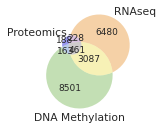

In [6]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
from matplotlib_venn import venn3
from sciutil import SciUtil

save = False
u = SciUtil()
gene_id = "ensembl_gene_id"
sns.set_style('white')
font = {'family': 'normal', 'size': 9}
matplotlib.rc('font', **font)
rcParams['figure.figsize'] = (2, 2)

p_df = pd.read_csv(prot_file)
print(len(p_df))
r_df = pd.read_csv(rna_file)
m_df = pd.read_csv(meth_file)
print(len(r_df))
# Filter the genes by the overlap from our RCM
p_df = p_df[p_df['padj_protein'].values < prot_padj_cutoff]
prot_genes = p_df[p_df['logFC_protein']> prot_logfc_cutoff][gene_id].values
# Print out numbers 
u.dp(['Number of sig. proteins ', len(p_df), f'Number with logFC > {prot_logfc_cutoff}:', len(prot_genes), len(prot_genes)/len(p_df), '%'])

m_df = m_df[m_df['padj_meth'].values < meth_padj_cutoff]
meth_genes = m_df[abs(m_df['CpG_Beta_diff']) > 0.1][gene_id].values
# Print out numbers 
u.dp(['Number of sig. CpGs ', len(m_df), f'Number with m.diff > {0.1}:', len(meth_genes), len(meth_genes)/len(m_df), '%', len(meth_genes)/187770]) # Divide by all CpGs

r_df = r_df[r_df['padj_rna'].values < rna_padj_cutoff]
rna_genes = r_df[abs(r_df['logFC_rna']) > rna_logfc_cutoff][gene_id].values
# Print out numbers 
u.dp(['Number of sig. RNA ', len(r_df), f'Number with logFC > {rna_logfc_cutoff}:', len(rna_genes), len(rna_genes)/len(r_df), '%'])

venn3([set(prot_genes), set(rna_genes), set(meth_genes)], set_labels=['Proteomics', 'RNAseq',
                                                                      'DNA Methylation'],
      set_colors=('#0101d7', '#e68e25', '#6aaf44'),)
plt.rcParams['svg.fonttype'] = 'none'
if save:
    plt.savefig(f'{fig_dir}Fig1B_Venn3_input_TvN_{meth_test_title}_{run_label}.svg')

In [7]:
print(len(set(rna_genes)&set(prot_genes)), len(set(rna_genes)&set(prot_genes))/len(p_df))

689 0.07271000422119038


In [8]:
## Check how many occur in "Direct" vs "Indirect flows"
direct = ["MDS",  "MDE", "TMDE", "TMDS", "TPDE", "TPDS"]
total_direct = 0
for r in direct:
    genes = df[df['Regulation_Grouping_2'] == r]
    total_direct += len(genes)
    
indirect = ["MDS_TMDE", "MDE_TMDS", "TPDE_TMDS", "TPDS_TMDE"]
total_indirect = 0
for r in indirect:
    genes = df[df['Regulation_Grouping_2'] == r]
    total_indirect += len(genes)
print(total_direct/(total_direct + total_indirect), total_indirect/(total_direct + total_indirect))

0.3658827031854719 0.6341172968145281


## Consolidate IDs

Since each of our datasets may have different identifiers that we want to use for downstream analyeses (such as GSEA or ORA) we want to make sure that the columns are merged together (so we don't get missing idenifiers).

In [5]:
reg_label = 'Regulation_Grouping_2'
# We want to merge the entrez columns together
entrez = df[[c for c in df.columns if 'entrezgene_id' in c]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
hgnc = df[[c for c in df.columns if 'hgnc_symbol' in c]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
external = df[[c for c in df.columns if 'external_gene_name' in c]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
ensembl = df[[c for c in df.columns if 'ensembl_gene_id' in c]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

entrez_updated = []
hgnc_updated = []
external_updated = []
ensembl_updated = []
count_nan = 0
for c in entrez:
    c = c.split(' ')
    added = False
    for e in c:
        if e != 'None' and float(e) != 0 and str(e) != '0.0' and str(e) != '0':
            entrez_updated.append(e)
            added = True
            break
    if not added:
        count_nan += 1
        entrez_updated.append(None)
for c in hgnc:
    c = c.split(' ')
    added = False
    for e in c:
        if not isinstance(e, float):
            hgnc_updated.append(e)
            added = True
            break
    if not added:
        hgnc_updated.append(None)
for c in external:
    c = c.split(' ')
    added = False
    for e in c:
        if not isinstance(e, float):
            external_updated.append(e)
            added = True
            break
    if not added:
        external_updated.append(None)
for c in ensembl:
    c = c.split(' ')
    added = False
    for e in c:
        if not isinstance(e, float):
            ensembl_updated.append(e)
            added = True
            break
    if not added:
        ensembl_updated.append(None)

In [6]:
len([e for e in entrez_updated if e == None])


1861

In [7]:
df['entrezgene_id'] = entrez_updated
## Update the RCM file
df['external_gene_name'] = external_updated
df['hgnc_symbol'] = hgnc_updated
df['ensembl_gene_id'] = ensembl_updated
print(df[reg_label].value_counts())
# Keep the DF that had regulatory labels assigned
df_og = df[df[reg_label] != 'None']
# Save the updated DF to a csv
df.to_csv(f'{data_dir}RCM_{meth_test_title}_{run_label}-GENES.csv', index=False)
cols = [c for c in df.columns if 'logFC' in c or 'padj' in c or 'entrezgene_id' == c or 'external_gene_name' == c or 'hgnc_symbol' == c or 'CpG_Beta_diff' in c or 'ensembl_gene_id' == c]
cols += [rcm.reg_grp_1_lbl, rcm.reg_grp_2_lbl, rcm.reg_grp_3_lbl]
df[cols].to_csv(f'{output_dir}RCM_{meth_test_title}_{run_label}-GENES.csv', index=False)



None         10303
TPDS_TMDE     1420
MDE_TMDS      1308
TPDE_TMDS     1069
TMDS           803
TPDS           539
MDS_TMDE       463
MDE            415
TMDE           313
TPDE           257
MDS            131
Name: Regulation_Grouping_2, dtype: int64


In [8]:
print(df[rcm.reg_grp_1_lbl].value_counts())

None                           10303
MDE_TMDS_M-neg_R-pos_P--        1308
TPDE_TMDS_M--_R-pos_P--          812
TPDS_TMDE_M-neg_R-neg_P--        710
TPDS_TMDE_M--_R-neg_P--          701
TMDS_M--_R--_P-neg               468
MDS_TMDE_M-pos_R-neg_P--         463
MDE_M-neg_R-pos_P-pos            415
TPDS_M--_R-neg_P-neg             337
TPDE_TMDS_M-pos_R-pos_P--        256
TPDS_TMDS_M-neg_R--_P-neg        256
TPDE_M--_R-pos_P-pos             222
TPDS_M-neg_R-neg_P-neg           202
TMDE_M--_R--_P-pos               142
TPDS_TMDE_M-neg_R--_P-pos        136
MDS_M-pos_R-neg_P-neg            131
TPDE_TMDS_M-pos_R--_P-neg         53
TPDE_M-pos_R-pos_P-pos            35
TPDE_TMDE_M-pos_R--_P-pos         27
MDE_TMDS_M-neg_R-pos_P-neg        16
TPDE_TMDS_M--_R-pos_P-neg         10
TPDS_TMDE_M-neg_R-neg_P-pos        9
TPDS_TMDE_M--_R-neg_P-pos          6
MDS_TMDE_M-pos_R-neg_P-pos         2
TPDE_TMDS_M-pos_R-pos_P-neg        1
Name: Regulation_Grouping_1, dtype: int64


In [9]:
print(df[rcm.reg_grp_2_lbl].value_counts())

None         10303
TPDS_TMDE     1420
MDE_TMDS      1308
TPDE_TMDS     1069
TMDS           803
TPDS           539
MDS_TMDE       463
MDE            415
TMDE           313
TPDE           257
MDS            131
Name: Regulation_Grouping_2, dtype: int64


In [10]:
print(df[rcm.reg_grp_3_lbl].value_counts())

None    10303
TMDS     3180
TMDE     2196
TPDS      539
MDE       415
TPDE      257
MDS       131
Name: Regulation_Grouping_3, dtype: int64


## Show how the patients cluster via RCM

Here we show a PCA of the patients and colour by the regulatory clusters.

We do this to show that it's not any specific information.

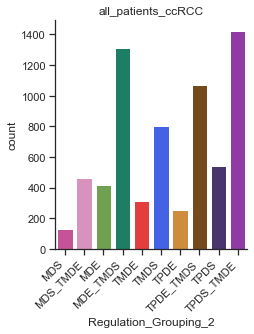

In [11]:
import itertools
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 3,2
sns.set(rc={'figure.figsize':(3,2)}, style='ticks')
#
colour_map = { 'MDS': '#d8419b', 'MDS_TMDE': '#e585c0', 'MDS_ncRNA': '#d880b4',
               'MDE': '#6aaf44', 'MDE_TMDS': '#0e8e6d', 'MDE_ncRNA': '#9edb77',
               'TMDE': '#fe2323', 'TMDS': '#2952ff',
               'TPDE': '#e68e25', 'TPDE_TMDS': '#844c0f',
                'TPDS': '#462d76', 'TPDS_TMDE': '#9b29b7'}

# colour_map = { 'MDS': '#ef4444', 'MDS_TMDE': '#db2777', 'MDS_ncRNA': '#d880b4',
#                'MDE': '#f87171', 'MDE_TMDS': '#f472b6', 'MDE_ncRNA': '#9edb77',
#                'TMDE': '#8b5cf6', 'TMDS': '#c4b5fd',
#                'TPDE': '#3730a3', 'TPDE_TMDS': '#4f46e5',
#                 'TPDS': '#818cf8', 'TPDS_TMDE': '#c7d2fe'}

# colour_map = { 'MDS': '#818cf8', 'MDS_TMDE': '#fca5a5', 'MDS_ncRNA': '#d880b4',
#                'MDE': '#fca5a5', 'MDE_TMDS': '#818cf8', 'MDE_ncRNA': '#9edb77',
#                'TMDE': '#fca5a5', 'TMDS': '#818cf8',
#                'TPDE': '#ef4444', 'TPDE_TMDS': '#818cf8',
#                 'TPDS': '#3730a3', 'TPDS_TMDE': '#fca5a5'}

sns.set_palette("Greys_r")
rcm_labels = ["MDS", "MDS_TMDE", "MDE", "MDE_TMDS", "TMDE", "TMDS", "TPDE", "TPDE_TMDS",  "TPDS", "TPDS_TMDE"]
colours = [colour_map[c] for c in rcm_labels]

g = sns.catplot(data=df_og, x=reg_label, kind="count", order=rcm_labels, palette=sns.color_palette(colours), 
               height=4)
plt.xticks(rotation=45, ha='right')
plt.title(f'{meth_test_title}')
plt.savefig(f'{fig_dir}barplot_{meth_test_title}_{run_label}TvN.svg')
plt.show()
